# Quantile Regression in AB Tests

In this post I'm going to show how quantile regression can be a very useful tool for analyzing AB tests.  Typically, as with a t-test, the test statistic is the mean of the distribution.  The test result will tell you the difference in the **mean** of Group B compared to the **mean** of Group A.  

In some cases, such as with [heavily skewed data](https://www.a2bofdatascience.com/2021/01/how-do-extreme-outliers-in-population.html), you should avoid tests of the mean.  In other cases, the mean simply might not be the best summary statistic for your problem.  Enter quantile regression.  

What is it?  Quantile regression allows you to estimate the effect of a treatment on the value of a difference in a given quantile.  For example, running a quantile regression on quantile 0.9 for groups A and B will give you the difference in the value of the 90th percentile of the outcome metric for these two groups.  So, the question is not, is the mean of B greater than the mean of A? The question is, is the quantile value X of B greater than the quantile value X of A?  

A note on terminology. Sometimes I write percentiles, sometimes quantiles. But they're the same thing simply expressed in different forms. Percentiles are, as you would expect expressed in terms of percentages, eg the 90th percentile represents the score for which 90% of the data falls below.  Quantiles are expressed in 0 to 1 terms. So quantile 0.9 is the same as percentile 90.  

In [41]:
set.seed(145)
suppressWarnings(library(tidyverse))
suppressWarnings(library(quantreg))

Let's simulate an AB test with two groups, A, and B, and 10,000 observations per group. We'll collect this simulated data into a dataframe:

In [42]:
n_obs_per_group = 10000
a = rnorm(n_obs_per_group, 10, 2)
b = rnorm(n_obs_per_group, 11, 4)

df = data.frame(group=c(rep('a', n_obs_per_group), rep('b', n_obs_per_group)),
           value=c(a, b))

The standard way to go about analyzing this data is to conduct a t-test, which you can calculate easily by hand, or by using a built-in function:

In [43]:
t.test(df$value[df$group=='a'], df$value[df$group=='b'])


	Welch Two Sample t-test

data:  df$value[df$group == "a"] and df$value[df$group == "b"]
t = -21.947, df = 14541, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.0725196 -0.8966511
sample estimates:
mean of x mean of y 
 10.01213  10.99671 


Conducting a standard t-test is perfectly valid.  Just like we would expect, the result is an estimated difference of ~1, and the estimate is highly statistically significant.  So if all of this is correct, what's the issue? Well, what if the mean is not really the best summary statistic for your problem?

Let's pretend that the outcome metric here is user engagement.  Further, let's assume that the purpose of the new feature is to increase user engagement, and you are specifically targeting users at the lower end of the engagement distribution.  If you are trying to increase engagment among the low-engaged, the mean value of engagement is a bad choice of summary statistic because it doesn't represent those at the lower end of the engagment distribution!

We can look at density plots of the observations of A and B:

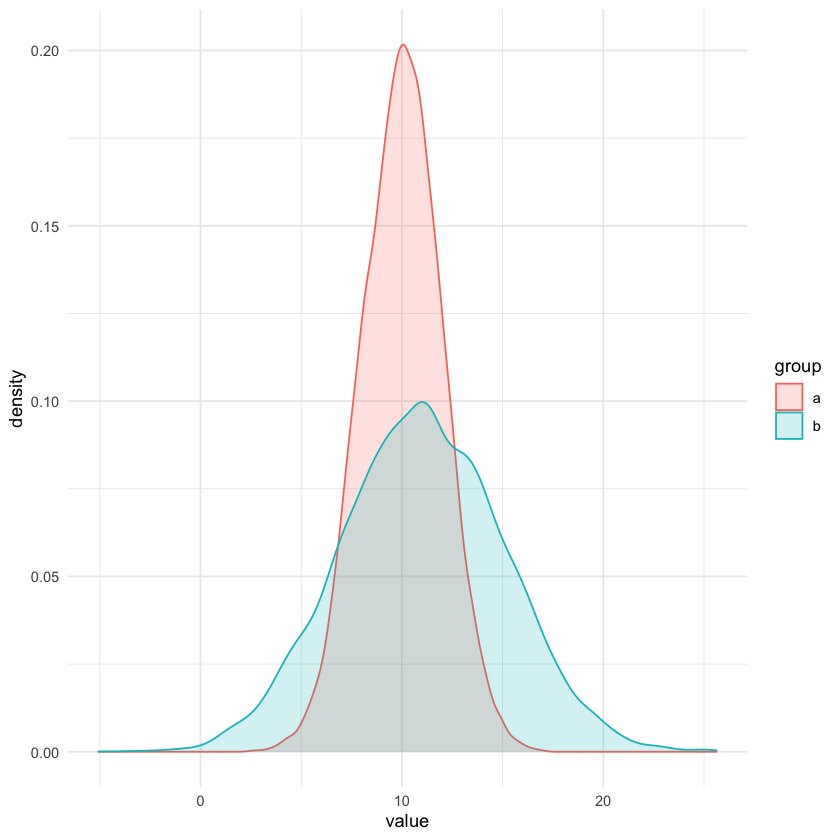

In [44]:
df %>% 
  ggplot(aes(x=value, color=group, fill=group)) + 
  geom_density(alpha=0.2) +
  theme_minimal()

We can see the differences in the distributions here, A is less spread than B, but B is centered further to the right than A.  This is exactly as we defined the distributions above: both are normally distributed, A has a mean of 10 with a standard deviation of 2, whereas B has a mean of 11 with a standard deviation of 4. 




# Quantile Regression

Let's run quantile regression on this data and look at the difference between three percentiles, the 10th (the low-engagement users), the 50th (the median) and the 90th (the high-engagement users).  

In [45]:
rq_fit = rq(value ~ group, data=df, tau=c(0.1, 0.5, 0.9))

rq_summary_output = rq_fit %>% 
  broom::tidy() %>%
  mutate(term=ifelse(term=='groupb' ,'B', 'A')) %>%
  rename(quantile=tau, group=term)

Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”

In [46]:
rq_summary_output

group,estimate,conf.low,conf.high,quantile
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
A,7.4484096,7.3884820,7.505386,0.1
B,-1.6428853,-1.7879820,-1.482717,0.1
A,10.0398638,9.9972581,10.082804,0.5
B,0.9401329,0.8443317,1.039288,0.5
A,12.5129784,12.4507634,12.581141,0.9
B,3.6374003,3.5076599,3.774785,0.9


In the summary table the "estimate" values for Group B represent the *difference from Group A*.  Let's zoom in on the median first.  Here we see that the median value of Group B is estimated to be .94 units higher than Group A, which is basically the same result as with the t-test because the median equals the mean under the normal distribution:

In [47]:
rq_summary_output %>% filter(quantile==0.5)

group,estimate,conf.low,conf.high,quantile
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
A,10.0398638,9.9972581,10.082804,0.5
B,0.9401329,0.8443317,1.039288,0.5


But where it gets interesting is when we look at the other percentiles. Let's look at the 90th percentile.  In this case the esimated difference between B and A is 3.6 units.  In other words, some users are showing very large gains as a result of the experimental feature.

In [48]:
rq_summary_output %>% filter(quantile==0.9)

group,estimate,conf.low,conf.high,quantile
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
A,12.51298,12.45076,12.581141,0.9
B,3.63740,3.50766,3.774785,0.9


Now, let's look at the 10th percentile.  In spite of an average treatment effect that is positive, and a very large positive effect of the treatment on the 90th percentile, the effect of the treatment on the 10th percentile is actually negative!  In fact, quite largely negtive as well, -1.6 units (which is huge if you consider that the effect at the median was +1 unit).  

In [49]:
rq_summary_output %>% filter(quantile==0.1)

group,estimate,conf.low,conf.high,quantile
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
A,7.448410,7.388482,7.505386,0.1
B,-1.642885,-1.787982,-1.482717,0.1


In this situation you can see how you can really get into trouble if you simply run a t-test to analyze your experiment.  If the goal of the feature change was to increase engagement among the low-engagement users, the feature failed horribly because users at the lower-end of the distribution were negatively impacted by the change.  

Quantile regression is really useful in situations in which the mean value of a distribution does not represent the observations you are most interested in.  It might be the case that your new feature is intended to decrease latency for those that suffer the greatest lags.  Or you might be hoping to increase engagement for those that are least engaged.  In these cases it doesn't really make sense to use the mean value of the distribution in a hypothesis test.  Quantile regression allows you to utilize other summary statistics of your distribution -- summary statistics that may be more in line with the product hypothesis.  

There is another use case in which quantiles come in handy -- [when the distribution of the outcome metric in the population is heavily skewed](https://www.a2bofdatascience.com/2021/01/how-do-extreme-outliers-in-population.html).  In this case the mean doesn't really represent any observations particularly well, and you should just stay away from t-tests all together.  Quantile regression for the win. 